### **Importing required packages:**

In [10]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

#import pygsm
from pygsm import GlobalSkyModel

import ephem
from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

ModuleNotFoundError: No module named 'pygsm'

### **Defining some constants:**

41.778914042798824


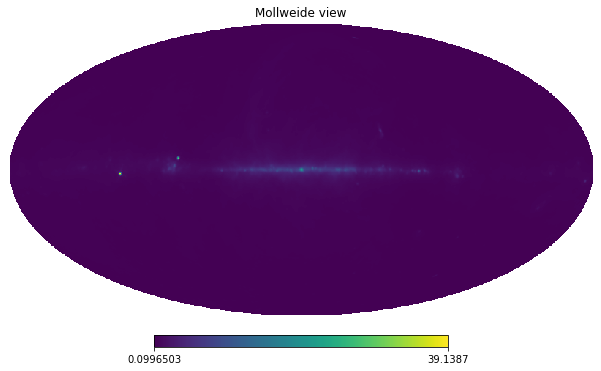

In [40]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2
f_stop = 4
No_of_Channels = 21
Channel_width = 0.1
N_SIDE = 16
T_hot = 373
T_cold = 273         #T_cold and T_hot in Kelvins
Time_in_UTC = '2022-05-23 00:00:00'  
latitude = 12.9716
longitude = 77.5946        #Latitude and longitude in degrees
altitude = 920            #Altitude in meters
alpha = 0.0065            #Temp. lapse rate (deg C per meter)
PI = 3.14159265

gsm = GlobalSkyModel(freq_unit='GHz')
spec_map = gsm.generate(2)
print(max(spec_map))
hp.mollview(spec_map)

### **Sky Model part code below:** 

In [ ]:
NPIX = hp.nside2npix(N_SIDE)
T = np.empty(NPIX)

gsm = GlobalSkyModel(freq_unit='GHz')

#**Generating maps for frequencies from 2 to 4 GHz in increment of 0.1 GHz:**

freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty(No_of_Channels)
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
spectrum = gsm.generate(freqs)

#Decreasing the resolution to NSIDE = 16

#spec = hp.pixelfunc.ud_grade(spectrum, N_SIDE)
df = pd.DataFrame(spectrum)
df = df.transpose()
df.columns = np.arange(f_start,f_stop+Channel_width,Channel_width)
df = df*1e-20 
#Basically 1e-20 factor is to convert MJy/Sr (PyGSM pack has this units) to W/m^2 Hz (SI units)



#Calculation of CMB intensity below for each frequencies

i=0
while i<No_of_Channels:
    #Calculation of CMB intensities at different frequencies below
    CMB_Int[i] = (2*h*math.pow(df.columns[i]*1e9,3.0)/(c*c*math.exp(h*df.columns[i]*1e9/k*TCMB)-1))
    #P_hot and P_cold calculation for calibration below
    P_hot[i] = 2*k*T_hot*(((h*df.columns[i])/(k*T_hot))/(math.exp((h*df.columns[i])/(k*T_hot))-1));   
    P_cold[i] = 2*k*T_cold*(((h*df.columns[i])/(k*T_cold))/(math.exp((h*df.columns[i])/(k*T_cold))-1));   
    P_dif[i] = P_hot[i] - P_cold[i]      
    
    i=i+1
    

CMB = pd.DataFrame(CMB_Int)
CMB = CMB.transpose()
CMB.columns = np.arange(f_start,f_stop+Channel_width,Channel_width)
CMB = CMB.transpose()
df = df.transpose()

CMB_plus_Gal = np.add(df, CMB.to_numpy())    #Adding CMB and Galactic contribution intensities in SI units. Recombination line intensity is added later.
print(CMB_plus_Gal)
print(P_hot)
print(P_cold)
print(P_dif)







### **LST calculation and Coordinate transform:**

In [ ]:
#Sidereal time calculation

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
print(lst)


#Checking the number of pixels

NPIX = hp.nside2npix(N_SIDE)
print(NPIX)

i=1
alt = np.empty(NPIX)
az = np.empty(NPIX)

#For every pixel, get the horizontal coordinate. 

while i<NPIX:
    coords = hp.pixelfunc.pix2ang(N_SIDE, i , nest = False, lonlat = True)
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
    
    radec = gc.transform_to(FK5(equinox = 'B2000')) 
    #I think there is some error here or maybe I got any concept wrong. When I use different equinox, say B1950, I am getting different radec as expected. But when I use that radec to transform to equitorial coords, I am getting same equi. coords again! 

    equi = radec.transform_to(AltAz(obstime = Time_in_UTC, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
    
    #Getting the magnitude of azimuthal value alone in deg
    #az[i-1]= equi.az .value 
    
    #Getting the magnitude of altitude value alone in deg
    #alt[i-1] = equi.alt .value 
    
    i=i+1

print(az) #List of az for each pixel as an array
print(alt) #List of alt for each pixel as an array


### **Recombination data: Intensity vs frequency**

In [34]:
df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)


df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
# #print(df)

# #ploting graph of intensity vs frequency

# plt.plot(df["Frequency"],df["Intensity"])
# plt.xlim(10,100)
# plt.xlabel('Frequency(GHz)')
# plt.ylabel('Intensity(W/(Hzm^2)')

# #plt.show()

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)

y = ius(np.arange(f_start,f_stop+Channel_width,Channel_width))
Rec_spec = pd.DataFrame(y)
print(Rec_spec)     #Getting intensities at the required frequencies

Total_sky = np.add(CMB_plus_Gal, Rec_spec.to_numpy())     #Adding reco. signal with gala. signal and CMB (All in SI units)
print(Total_sky)

P_dif = pd.DataFrame(P_dif)
print(P_dif)

T_sky = (T_hot - T_cold)* np.divide(Total_sky,P_dif)   
#print(T_sky)

plt.scatter(T_sky.index,np.array(T_sky[2000]))




/tmp/ipykernel_24593/1588911273.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)


NameError: name 'f_start' is not defined

### **Function to generate map of visible sky given the location and time:**

In [ ]:
NPIX = hp.nside2npix(16)
print(NPIX)

gsm = GlobalSkyModel(freq_unit='GHz')


def Visible_Sky(frequency, latitude, longitude, altitude, T):           #Here frequency is taken in GHz, lat and lon in degrees and T is the format 'YYYY-MM-DD HH:MM:SS.SS'
    spectrum = gsm.generate(frequency)
    spectrum = hp.pixelfunc.ud_grade(spectrum, 16)                      #Reducing the resolution to NSIDE=16

    i=1

    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(N_SIDE, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = T, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
        
        #If alt<0 in horizontal coordinates, that is not visible for the observer. So, suxh pixels are given minimum value (grey in map)
        if (equi.alt<0):
            spectrum[i-1] = -1.6375e+30
    
        i = i+1  
    hp.mollview(spectrum)
    
spectrum_value = Visible_Sky(2,latitude,longitude,altitude,Time_in_UTC)
print(spectrum_value)


In [ ]:
#Changing intensity to temperature scale

# for cols in df:
#     df[cols] = df[cols].apply(lambda x:(h* df.columns*1e9)/(k) * (0.5 + (x*1.25664e-20*c*c/(2*h*df.columns*df.columns*df.columns*1e27))))


### **Calculating az, alt for each pixels and adding refraction correction:**

In [ ]:
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R


def beam_def(freq, az, alt):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))

In [ ]:
alt = np.empty(NPIX)
new_alt = np.empty(NPIX)


i=1
while i<NPIX:           #Working on each pixel
    coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
    equi = gc.transform_to(AltAz(obstime = Time_in_UTC, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
    alt[i-1] = equi.alt.value
    new_alt[i-1] = refraction(equi.alt.value, altitude) 
    
    j=0
    while j< No_of_Channels:
        cwt = beam_def(df.columns[j],equi.az.value, new_alt[i-1])
        j=j+1
        if (cwt>0):
            
            
    
    i=i+1
    
print(alt)
print(new_alt)


### **Antenna part**

In [ ]:
def beam_def(freq, az, alt):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))
    
print(beam_def(2,30,30))

In [9]:
# generate random Gaussian values
from random import seed
from random import gauss
# seed random number generator
# seed(0)

def gasdev(mean, std, no_of_values):
    nums= []
    for _ in range(no_of_values):
        value = gauss(mean, std)
        nums.append(value)
    return nums    

print(gasdev(0,1,1))


[1.2654475820201811]


In [ ]:

# generate random Gaussian values
from numpy.random import seed
from numpy.random import randn
# seed random number generator
seed(1)
# generate some Gaussian values
values = randn(10)
print(values)